# XGBoost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1223117093.py:68: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['roc10'] = data['close'].pct_change(10)


Validation Accuracy: 0.7461424493188307
Test Total Return: inf%
Average Daily Return: 261.4593%
Daily Volatility: 1284.2639%


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


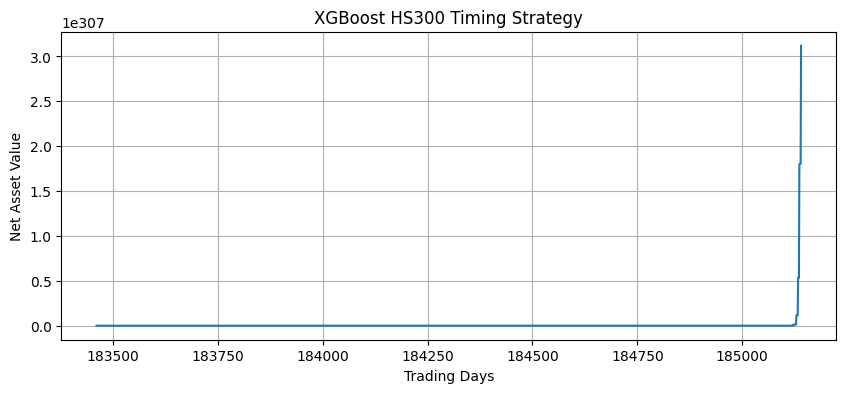

In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from google.colab import drive

drive.mount('/content/drive')

# Load data
datadir = "/content/drive/My Drive/441final/hs300_clean_data.csv"
data = pd.read_csv(datadir)

# Sort & target
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time').reset_index(drop=True)

threshold = 0.002
ret = (data['close'].shift(-1) - data['close']) / data['close']
data['target'] = np.where(ret > threshold, 1, np.where(ret < -threshold, 0, np.nan))

# Feature engineering
for i in range(1, 11):
    data[f'open_{i}'] = data['open'].shift(i)
    data[f'close_{i}'] = data['close'].shift(i)
    data[f'high_{i}'] = data['high'].shift(i)
    data[f'low_{i}'] = data['low'].shift(i)
    data[f'volume_{i}'] = data['volume'].shift(i)

data['ma10'] = data['close'].rolling(10).mean()
data['ma20'] = data['close'].rolling(20).mean()
data['ma10_slope'] = data['ma10'].diff()
data['ma20_slope'] = data['ma20'].diff()

delta = data['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
rs = gain.rolling(14).mean() / loss.rolling(14).mean()
data['rsi14'] = 100 - (100 / (1 + rs))

ema12 = data['close'].ewm(span=12).mean()
ema26 = data['close'].ewm(span=26).mean()
data['macd'] = ema12 - ema26
data['macd_signal'] = data['macd'].ewm(span=9).mean()

data['std20'] = data['close'].rolling(20).std()
data['boll_up'] = data['ma20'] + 2 * data['std20']
data['boll_dn'] = data['ma20'] - 2 * data['std20']
data['boll_width'] = (data['boll_up'] - data['boll_dn']) / data['ma20']

low_9 = data['low'].rolling(9).min()
high_9 = data['high'].rolling(9).max()
data['rsv'] = (data['close'] - low_9) / (high_9 - low_9)
data['kdj_k'] = data['rsv'].ewm(alpha=1/3).mean()
data['kdj_d'] = data['kdj_k'].ewm(alpha=1/3).mean()
data['kdj_j'] = 3 * data['kdj_k'] - 2 * data['kdj_d']

data['tr'] = np.maximum(
    data['high'] - data['low'],
    np.maximum(
        abs(data['high'] - data['close'].shift(1)),
        abs(data['low'] - data['close'].shift(1))
    )
)
data['atr14'] = data['tr'].rolling(14).mean()

data['mom10'] = data['close'] - data['close'].shift(10)
data['roc10'] = data['close'].pct_change(10)

data.dropna(inplace=True)

features = (
    [f'open_{i}' for i in range(1, 11)] +
    [f'close_{i}' for i in range(1, 11)] +
    [f'high_{i}' for i in range(1, 11)] +
    [f'low_{i}' for i in range(1, 11)] +
    [f'volume_{i}' for i in range(1, 11)] +
    [
        'ma10','ma20','ma10_slope','ma20_slope',
        'rsi14','macd','macd_signal',
        'boll_up','boll_dn','boll_width',
        'kdj_k','kdj_d','kdj_j',
        'atr14','mom10','roc10'
    ]
)

n = len(data)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_data = data.iloc[:train_end]
val_data = data.iloc[train_end:val_end]
test_data = data.iloc[val_end:]

X_train = train_data[features]
y_train = train_data['target']
X_val = val_data[features]
y_val = val_data['target']
X_test = test_data[features]
y_test = test_data['target']

model = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1.0,
    min_child_weight=3,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
print("Validation Accuracy:", accuracy_score(y_val, model.predict(X_val)))

test_data = test_data.copy()
test_data['prob_up'] = model.predict_proba(X_test)[:, 1]
test_data['strategy_ret'] = np.where(
    test_data['prob_up'] > 0.5,
    (test_data['close'].shift(-1) - test_data['close']) / test_data['close'],
    0
)

daily_returns = test_data['strategy_ret'].dropna()
cum_return = (1 + daily_returns).cumprod() - 1

print("Test Total Return:", f"{cum_return.iloc[-1]:.2%}")
print("Average Daily Return:", f"{daily_returns.mean():.4%}")
print("Daily Volatility:", f"{daily_returns.std():.4%}")

plt.figure(figsize=(10,4))
plt.plot((1 + daily_returns).cumprod())
plt.title("XGBoost HS300 Timing Strategy")
plt.xlabel("Trading Days")
plt.ylabel("Net Asset Value")
plt.grid(True)
plt.show()


In [5]:
# !pip install pandas scikit-learn xgboost

In [6]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import accuracy_score
# import xgboost as xgb

# from google.colab import drive
# drive.mount('/content/drive')

# datadir = "/content/drive/My Drive/441final/hs300_clean_data.csv"
# data = pd.read_csv(datadir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# data['time'] = pd.to_datetime(data['time'])
# data = data.sort_values('time').reset_index(drop=True)

# # Target：0.2%（avoid noise）
# threshold = 0.002
# ret = (data['close'].shift(-1) - data['close']) / data['close']

# data['target'] = np.where(ret > threshold, 1,
#                    np.where(ret < -threshold, 0, np.nan))

# # Lag Features：past ten days
# for i in range(1, 11):
#     data[f'open_{i}'] = data['open'].shift(i)
#     data[f'close_{i}'] = data['close'].shift(i)
#     data[f'high_{i}'] = data['high'].shift(i)
#     data[f'low_{i}'] = data['low'].shift(i)
#     data[f'volume_{i}'] = data['volume'].shift(i)

# # MA
# data['ma10'] = data['close'].rolling(10).mean()
# data['ma20'] = data['close'].rolling(20).mean()
# data['ma10_slope'] = data['ma10'].diff()
# data['ma20_slope'] = data['ma20'].diff()

# # RSI 14
# delta = data['close'].diff()
# gain = delta.clip(lower=0)
# loss = -delta.clip(upper=0)
# rs = gain.rolling(14).mean() / loss.rolling(14).mean()
# data['rsi14'] = 100 - (100 / (1 + rs))

# # MACD
# ema12 = data['close'].ewm(span=12).mean()
# ema26 = data['close'].ewm(span=26).mean()
# data['macd'] = ema12 - ema26
# data['macd_signal'] = data['macd'].ewm(span=9).mean()

# # BOLL
# data['std20'] = data['close'].rolling(20).std()
# data['boll_up'] = data['ma20'] + 2 * data['std20']
# data['boll_dn'] = data['ma20'] - 2 * data['std20']
# data['boll_width'] = (data['boll_up'] - data['boll_dn']) / data['ma20']

# # KDJ
# low_9 = data['low'].rolling(9).min()
# high_9 = data['high'].rolling(9).max()
# data['rsv'] = (data['close'] - low_9) / (high_9 - low_9)
# data['kdj_k'] = data['rsv'].ewm(alpha=1/3).mean()
# data['kdj_d'] = data['kdj_k'].ewm(alpha=1/3).mean()
# data['kdj_j'] = 3 * data['kdj_k'] - 2 * data['kdj_d']

# # ATR
# data['tr'] = np.maximum(
#     data['high'] - data['low'],
#     np.maximum(abs(data['high'] - data['close'].shift(1)),
#                abs(data['low'] - data['close'].shift(1)))
# )
# data['atr14'] = data['tr'].rolling(14).mean()

# # Momentum & ROC
# data['mom10'] = data['close'] - data['close'].shift(10)
# data['roc10'] = data['close'].pct_change(10)

# # drop NA
# data.dropna(inplace=True)


# # Feature List
# features = (
#     [f'open_{i}' for i in range(1, 11)] +
#     [f'close_{i}' for i in range(1, 11)] +
#     [f'high_{i}' for i in range(1, 11)] +
#     [f'low_{i}' for i in range(1, 11)] +
#     [f'volume_{i}' for i in range(1, 11)] +
#     [
#         'ma10','ma20','ma10_slope','ma20_slope',
#         'rsi14','macd','macd_signal',
#         'boll_up','boll_dn','boll_width',
#         'kdj_k','kdj_d','kdj_j',
#         'atr14','mom10','roc10'
#     ]
# )

# X = data[features]
# y = data['target']

# # TimeSeries Cross-Validation

# tscv = TimeSeriesSplit(n_splits=5)

# best_acc = 0
# best_model = None

# for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#     model = xgb.XGBClassifier(
#         n_estimators=600,
#         max_depth=8,
#         learning_rate=0.02,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         gamma=1.0,
#         min_child_weight=3,
#         eval_metric='logloss',
#         random_state=42
#     )

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)

#     print(f"Fold {fold+1} Accuracy: {acc:.4f}")

#     if acc > best_acc:
#         best_acc = acc
#         best_model = model

# print("=====================================")
# print(f"Best Accuracy: {best_acc:.4f}")

/tmp/ipython-input-2673490846.py:62: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['roc10'] = data['close'].pct_change(10)


Fold 1 Accuracy: 0.7383
Fold 2 Accuracy: 0.7454
Fold 3 Accuracy: 0.7455
Fold 4 Accuracy: 0.7488
Fold 5 Accuracy: 0.7464
Best Accuracy: 0.7488


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1223117093.py:68: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['roc10'] = data['close'].pct_change(10)


Validation Accuracy: 0.7461424493188307
Test Total Return: inf%
Average Daily Return: 261.4593%
Daily Volatility: 1284.2639%


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


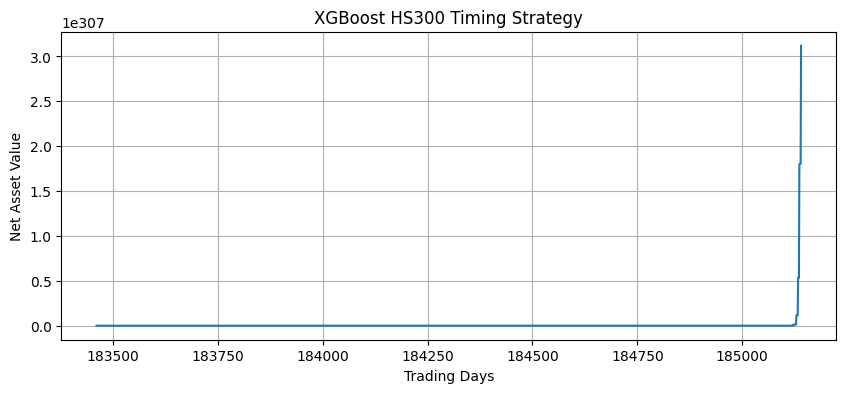